Peter Stewart (pvstewar@gmail.com)  

# Exploring Distributed Data Storage for Network Monitoring Applications  

# Introduction

The goal of this project is to build a model for a large-scale network intrusion detection system (IDS) and to apply concepts from the course to certain aspects of this model. Many of the components of the system are outside of the scope of the course, so the following report will try to relate the project methodology and results to the Modelling module of the course. It will be important to cover some of the basic details of the components involved in the larger model, but the primary focus will be around the storage model and how the concepts covered in the course Modelling module shaped the experiences and choices made in completing the project.

This project is intended to be the first step in the process of implementing a network monitoring solution that leverages multiple open-source IDS systems to gather data from multiple discrete or interconnected networks and to organize the data in a high performing, robust and secure central database which can be leveraged to provide high level network data analysis, and visualization to achieve the goals of intrusion detection, prevention, and mitigation.



# Background

With the growth of information technology and the greater complexity of the enterprise network environment driven by trends such as remote work, internet of things, and the use of cloud computing, the value of network intrusion detections systems has grown. According to a 2022 study (IBM, 2022) of 550 organizations across many countries and industries affected by data breaches, the average cost of a data breach in 2022 was $4.35 million. Of the studied organizations 83% had been victimized multiple times, indicating repeated failure to detect intrusions. The study also found that organizations with fully developed security AI and automation had an average cost of data breach of $3.15 million versus those organizations without these systems that had an average cost of $6.20 million. So, there is a high value in developing intrusion detection systems and then leveraging high level analytics and machine learning to act on that data. While there are many ways to implement security in an enterprise network, intrusion detection has the potential to catch the threat at the entry point and prevent the intrusion from taking hold within the internal systems of the enterprise.
	
There are many types of IDS available, many of which are free and open source, but they generally fall into two categories in terms of function, Signature-based IDS and Anomaly or Behavior-based IDS. They also tend to be split into two categories in terms of implementation, Network-based IDS, and Host-based IDS (CISOMag, 2021). For the purposes of this project, it isn’t necessary to focus on the functionality of the data, but in general the underlying assumption is that the most valuable application will be utilizing AI and machine learning to focus on the anomaly and behavior-based IDS in order to create automated alerts and actions to prevent a breach. That component of the system is outside of the scope of this project, but it makes sense to discuss potential in that area in the context of decisions about the database system to be used. The implementation types will be discussed in terms of the sample data that will be integrated in this project. There will be data from both types of IDS tools utilized and more details will be included in the results and discussion section of this report.


# Methodology

The main goal of this project was to build out a distributed and flexible database system that could handle ingesting of multiple varying datasets that are produced by various network monitoring tools. So, to that end the focus of this section will be the process of selecting the right database type, the challenges faced through that process and what led to the final decision of a database platform to use. After detailing that process, the focus will shift to the sample data used and some understanding of the tools that produced them and finally will be the explanation of the build process for the project database.
	
The database selection process was daunting because of the large variety of database systems to choose from. In theory, just about any database system we’ve studied in the course so far would be an option but there were a few main factors driving the decision. First was the ability to run the production database on a distributed file system to handle large volumes of data and large numbers of end points connecting and uploading data. Even though this project was not going to require a distributed system, it was important to be able to at least move to distributed and redundant file system once the design is implemented and scaled up. The second factor was that the DBMS has flexible architecture to be able to handle varying schemas. There are many different network monitoring tools and often the data they collect is similar but they each have advantages and weaknesses, so the ideal solution is to use many tools and compile the data into a single file store. Another consideration was that the system be open-source, as explained in the Stonebreaker’s tenth rule (Stonebreaker, 2011), open-source offers a higher level of long-term stability, also open source tends to be a better way to ensure that bugs in code are seen and fixed before they become security vulnerabilities. The fourth requirement was more of a personal preference that the DBMS work well with python for the sake of familiarity and flexibility to work with the many python libraries for analysis and management. This is also in keeping with Stonebreaker’s second rule, there are many advantages to using a higher-level language like Python and if implemented correctly it should not be an impediment on performance. Based on these requirements the two systems that seemed to be a good fit were MongoDB and Spark. Overall, both systems seemed to be well-regarded in the community and met the requirements. 
	
MongoDB has the advantage of using the flexible document database, BSON format which allows for nesting of different database structures and does not require a pre-defined schema. Seeing as this would be a good fit for the varying types of data we will be importing from our various IDSs, this seemed like a good fit so the first step in the project was to implement a MongoDB database in Google Cloud Platform. The approach to getting MongoDB running with GCP followed the quiklab from the “Injest and Storage” module in the course. This will create a statefulset with headless service which allows our cluster to have the persistent storage needed in order to store our MongoDB instance and save data to it. After following those instructions and getting the MongoDB running on GCP, the goal was to connect remotely from a desktop machine using python and the PyMongo library to upload some sample datasets and replicate the process of uploading the network monitoring data from various end points. Using PyMongo to connect to a remote server requires creating a connection string formatted as shown below with the IP address of the server running MongoDB. Since this is a headless service, a port forwarding rule must be in place to link the individual pod ports together and ensure that when we enter one of the pod IP addresses in our connection string, we will forward the MongoDB port 27017 to an open port on each pod. This can be accomplished by adding a nodeport rule to our .yaml file defining our container instance (see below “nodeport” cell). After adding the nodeport in the CLI, it was also necessary to add a firewall rule for our default network to allow access to port 27017. In theory after these actions are done, we should be able to use the connection string to connect to GCP from the notebook, however this was not accomplished after many attempts and settings changes and eventually time constraints required a change of course.


In [ ]:
# nodeport
# This code was uploaded to the GCP instance and run in the cluster, and varified to be working:

apiVersion: v1
kind: Service
metadata:
  name: mongo-nodeport
spec:
  type: NodePort
  selector:
    app.kubernetes.io/name: netmon-db
  ports:
      # By default and for convenience, the `targetPort` is set to the same value as the `port` field.
    - port: 27017
      targetPort: 27017
      # Optional field
      # By default and for convenience, the Kubernetes control plane will allocate a port from a range (default: 30000-32767)
      #nodePort: 30007

### Connecting to MongoDB from Jupyter NB using pymongo

In [2]:
#Importing libraries for below sections
import pymongo
from pymongo import MongoClient
import kubernetes
import csv

In [2]:
#First attempt to connect using Google Cloud Platform using IP addresses assigned to GCP cluster
import certifi
ca = certifi.where()
uri = 'mongodb://<insert GCP uri here>'

In [3]:
#Defining the connection to the server
client = MongoClient(uri, tlsCAFile=ca)

In [4]:
#Testing connection by pinging the server
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

mongodb0.34.67.169.27:27017: [Errno 11001] getaddrinfo failed,mongodb1.34.67.169.27:27017: [Errno 11001] getaddrinfo failed,mongodb2.34.67.169.27:27017: [Errno 11001] getaddrinfo failed, Timeout: 30s, Topology Description: <TopologyDescription id: 6446fb11b90c6b5efd6d6bd0, topology_type: ReplicaSetNoPrimary, servers: [<ServerDescription ('mongodb0.34.67.169.27', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('mongodb0.34.67.169.27:27017: [Errno 11001] getaddrinfo failed')>, <ServerDescription ('mongodb1.34.67.169.27', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('mongodb1.34.67.169.27:27017: [Errno 11001] getaddrinfo failed')>, <ServerDescription ('mongodb2.34.67.169.27', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('mongodb2.34.67.169.27:27017: [Errno 11001] getaddrinfo failed')>]>


# Methodology (continued)

In researching a solution to the networking problem in became apparent that many MongoDB applications are approaching this setup from a different angle by using MongDB Atlas. Atlas is a service available directly through MongoDB which allows a user to set up a database using a web-based graphical interface. Interestingly, the service can be set up through Amazon AWS, Google Cloud Platform, or Azure. This seemed a good substitute to try and it did offer similar options in terms of the google server geographic regions and many options to customize the cluster device capabilities. The setup process was straightforward, and they offered a free tier that was restricted in terms of machine capabilities and storage space (500MB). The web-based set up process proved successful in getting a MongoDB instance running on a GCP cluster similar to the previous attempt and offered additional security by allowing users to enter an IP address to allow remote connections only through that IP. As shown in the cell below, a successful connection was set up on the remote machine running the Jupyter Notebook and one of the sample CSV files was imported as a new collection in the DB. When attempting to import a second CSV the space limit was reached and the operation failed. The size on disc after the import was actually larger than the size of the original CSV file so the size limit was more restrictive than initially anticipated.

In [3]:
#Second connection attempt using MongDB Atlas
import certifi
ca = certifi.where()
uri = 'mongodb+srv://<insert custom uri here>'


In [4]:
client = MongoClient(uri, tlsCAFile=ca)

In [5]:
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [6]:
#Show the name of the databases currently in use (netmon_db was added when the db was set up on the mongo site)
client.list_database_names()

['netmon_db', 'admin', 'local']

In [9]:
#Creating a collection to import our CSV data into
IDS_1 = client.netmon_db['IDS_1']
client.netmon_db.list_collection_names()

['IDS_1']

In [6]:
# Create a python variable for our DB
db = client.netmon_db

### Import and transform Data in MongoDB

In [11]:
# modified from https://stackoverflow.com/questions/62072355/how-to-import-csv-file-into-mongodb-using-python
# First create a variable with the columnn names from the CSV
with open('1.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    col_names = reader.fieldnames

print(col_names)


[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [32]:
# modified from https://stackoverflow.com/questions/62072355/how-to-import-csv-file-into-mongodb-using-python
# Here, importing the CSV file into a dictionary for import into mongo collection
with open('1.csv', 'r') as csvfile:
    header = col_names
    reader = csv.reader(csvfile)

    for row in reader:
        doc={}
        for n in range(0,len(header)):
            doc[header[n]] = row[n]

        db.IDS_1.insert_one(doc)

After the import we see the following at the mongoDB Atlas GUI on the web:

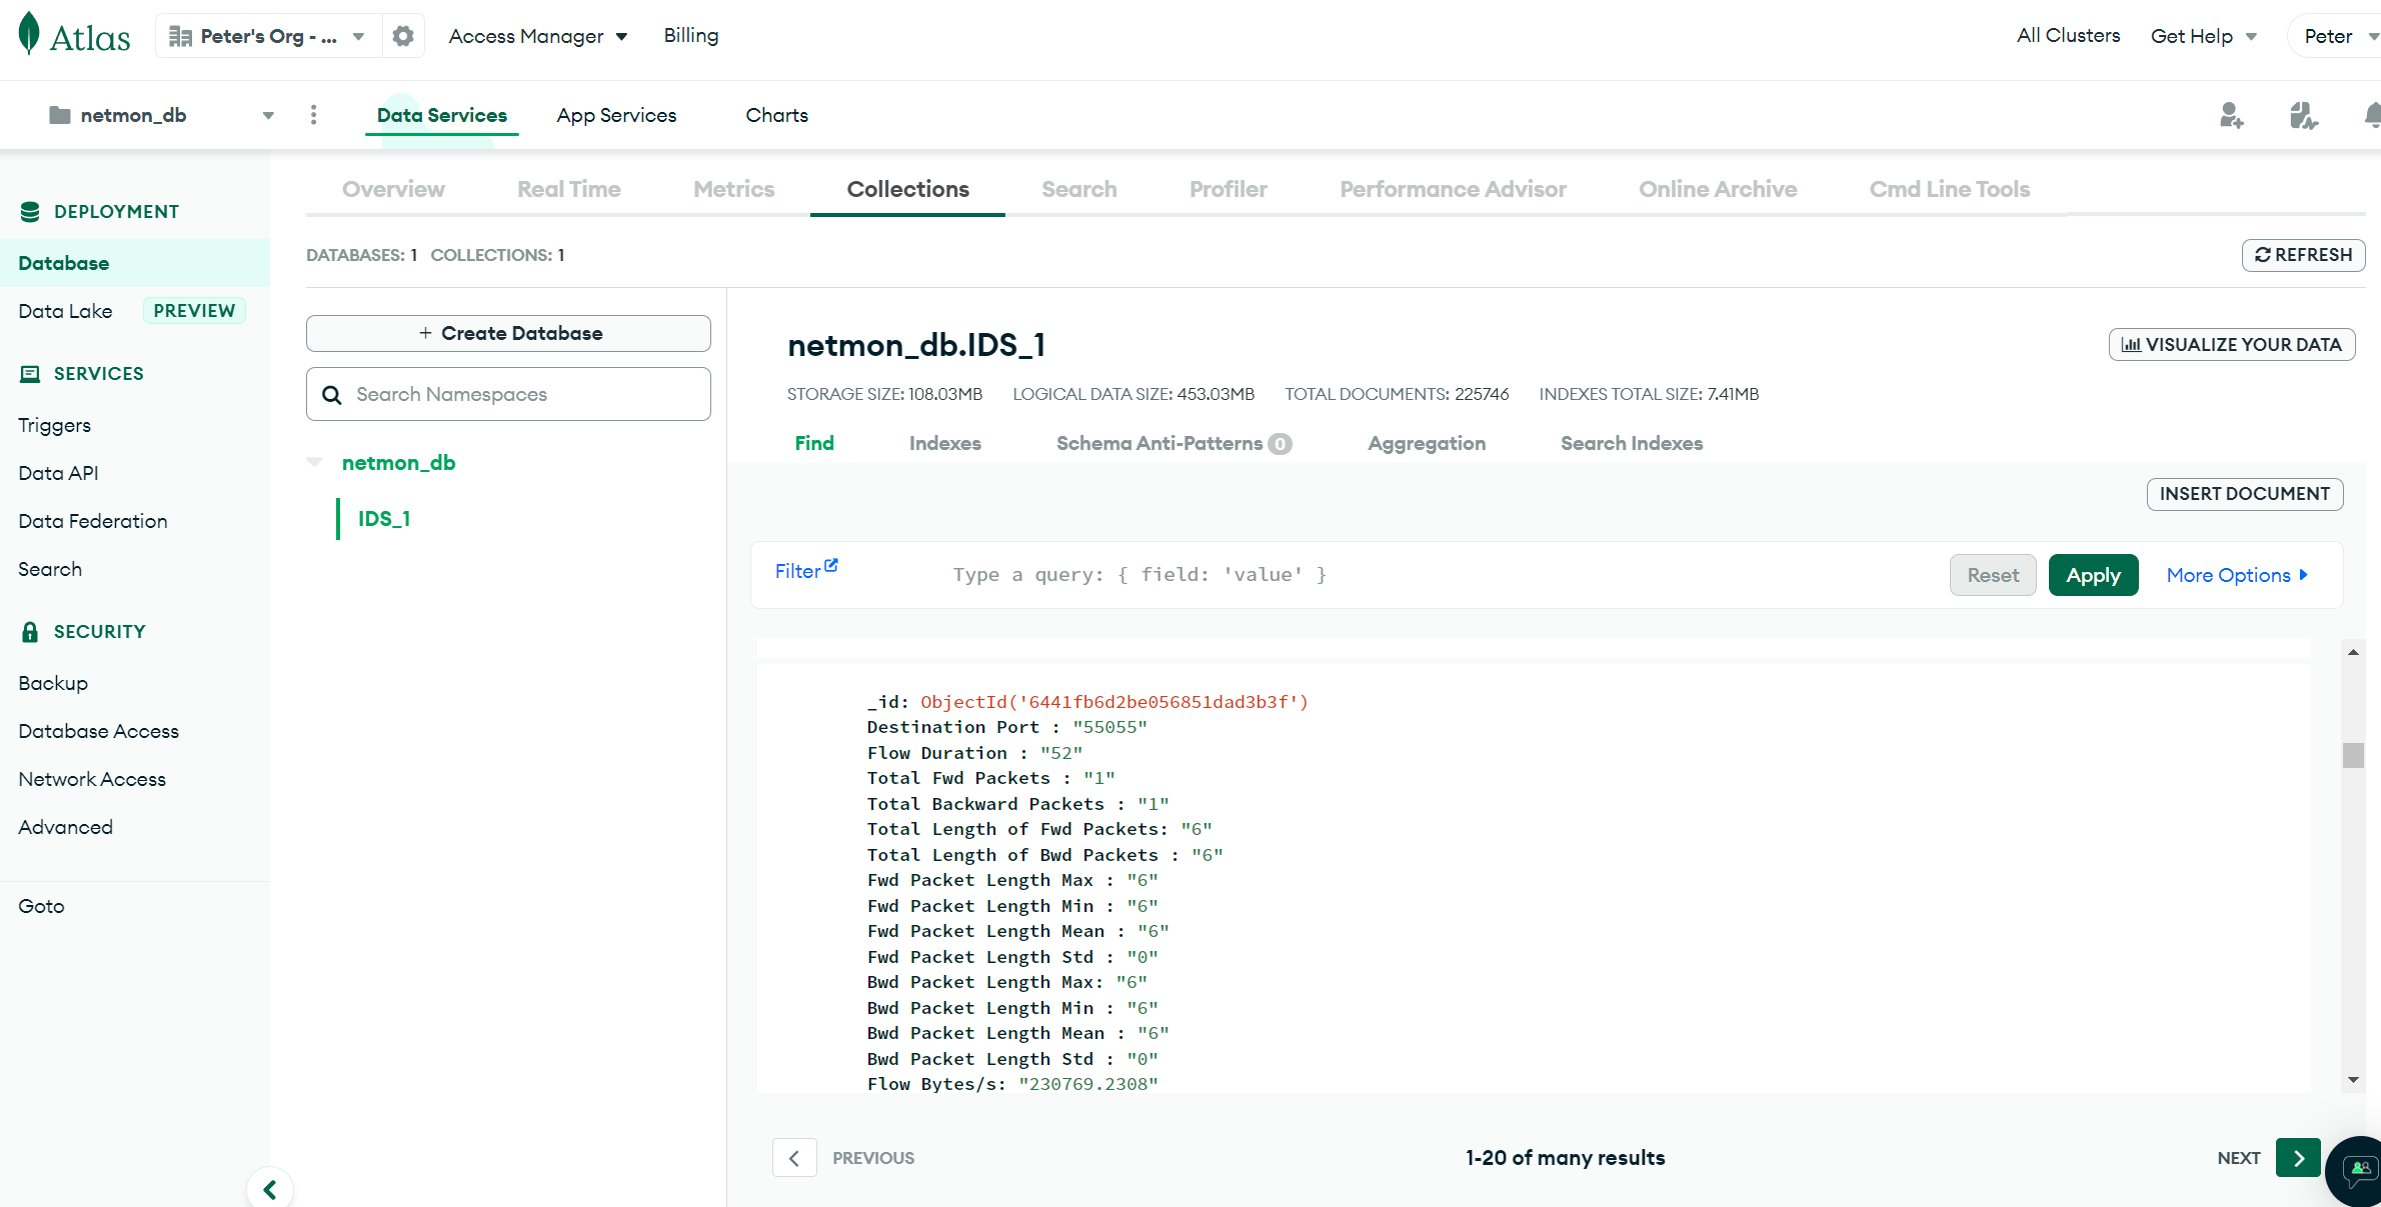

In [ ]:
# Now we'll do the same process with the next day data from our sample

with open('2.csv', 'r') as csvfile:
    header = col_names
    reader = csv.reader(csvfile)

    for row in reader:
        doc={}
        for n in range(0,len(header)):
            doc[header[n]] = row[n]

        db.IDS_1.insert_one(doc)

Error above shows that we have run out of space to store aditional data in the datebase. Below is additional info on what we were able to do in the previous cell.

In [37]:
#displaying some basic info about our MongoDB instance
col = db.IDS_1
print(col.index_information())
print(col.count_documents({}))
print(col.find_one(skip=1))

{'_id_': {'v': 2, 'key': [('_id', 1)]}}
252590
{'_id': ObjectId('6441fb6c2be056851dad3b3d'), ' Destination Port': '54865', ' Flow Duration': '3', ' Total Fwd Packets': '2', ' Total Backward Packets': '0', 'Total Length of Fwd Packets': '12', ' Total Length of Bwd Packets': '0', ' Fwd Packet Length Max': '6', ' Fwd Packet Length Min': '6', ' Fwd Packet Length Mean': '6', ' Fwd Packet Length Std': '0', 'Bwd Packet Length Max': '0', ' Bwd Packet Length Min': '0', ' Bwd Packet Length Mean': '0', ' Bwd Packet Length Std': '0', 'Flow Bytes/s': '4000000', ' Flow Packets/s': '666666.6667', ' Flow IAT Mean': '3', ' Flow IAT Std': '0', ' Flow IAT Max': '3', ' Flow IAT Min': '3', 'Fwd IAT Total': '3', ' Fwd IAT Mean': '3', ' Fwd IAT Std': '0', ' Fwd IAT Max': '3', ' Fwd IAT Min': '3', 'Bwd IAT Total': '0', ' Bwd IAT Mean': '0', ' Bwd IAT Std': '0', ' Bwd IAT Max': '0', ' Bwd IAT Min': '0', 'Fwd PSH Flags': '0', ' Bwd PSH Flags': '0', ' Fwd URG Flags': '0', ' Bwd URG Flags': '0', ' Fwd Header Leng

In [38]:
#Looking at how many of our records have the label benign
find = {' Label':'BENIGN'}
sort = [('BENIGN',pymongo.DESCENDING)]
skip = 1
limit = 10

doc_count = col.count_documents(find, skip=skip)
results = col.find(find).sort(sort).skip(skip).limit(limit)
print(doc_count)

124553


In [40]:
#Code and info on indexes from https://www.analyticsvidhya.com/blog/2020/09/mongodb-indexes-pymongo-tutorial/
#Since the output of actually showing the documents in the above query would be too large to be useful, let's instead show some execution stats
print(col.find(find).explain()['executionStats'])

{'executionSuccess': True, 'nReturned': 124554, 'executionTimeMillis': 441, 'totalKeysExamined': 0, 'totalDocsExamined': 252590, 'executionStages': {'stage': 'COLLSCAN', 'filter': {' Label': {'$eq': 'BENIGN'}}, 'nReturned': 124554, 'executionTimeMillisEstimate': 293, 'works': 252592, 'advanced': 124554, 'needTime': 128037, 'needYield': 0, 'saveState': 252, 'restoreState': 252, 'isEOF': 1, 'direction': 'forward', 'docsExamined': 252590}, 'allPlansExecution': []}


From the info above we can see that our query returned ('nReturned': 124554) a little less than half of the total documents ('totalDocsExamined': 252590) which had were labeled Benign. Execution time was ('executionTimeMillisEstimate': 293) so about 293 miliseconds. We can use this information to try to speed up processing by using different fields as indeces in our DB.

In [41]:
#Now lets see if we can speed up processing by adding label as an index, since this field is going to be key in our analysis.
col.create_index('Label')
print(col.index_information())

OperationFailure: you are over your space quota, using 514 MB of 512 MB, full error: {'ok': 0, 'errmsg': 'you are over your space quota, using 514 MB of 512 MB', 'code': 8000, 'codeName': 'AtlasError'}

It's clear at this point that the size limit is going to be a major problem but we've seen some of the capabilities of MongoDB so for the purposes of this project it seems that the best option at this point is to evaluate the usefulnes of MongoDB based on the experiences above and move to the other DB option of interest, Spark and sepcifically the Python version PySpark.

### Pyspark

# Methodology (continued)

At this point having set up a basic MongoDB it made sense to move to the second database option that also fulfilled the requirements, PySpark. This seemed like the logical next step since we had recently set up a working J2 VM that would not have the same resource limitations or technical issues as the previous attempts with MongoDB. The VM for this application was the m3.small with 2 CPUs, 6GB ram and 20GB storage, so this seemed sufficient to try out importing a variety of data to simulate the demands of the application design. The set up process for this machine was to take a Ubuntu VM and then create a docker image with our Jupyter notebook environment. One advantage to this setup is that we can easily re-create this environment on different hardware or virtual machines, and this will help to be able to take advantage of distributed computing and storage as well as scaling up or potentially changing cloud platforms as needed. This is not an exclusive feature with PySpark, as MongoDB can be set up in a similar way but the experience in this case was a bit smoother with PySpark. The first step in using PySpark was to decide on the data structure to use. The options available for data storage in PySpark are RDD (which we used in the lab) or Dataframe, which is built on the same basic structure as RDD but adds an abstraction layer which resembles an SQL database or pandas dataframe with columns and a schema (Databricks, 2023). For this use case the dataframe is the clear choice. When importing the data, PySpark can infer a schema by looking at the incoming columns and programmatically deciding how to categorize the datatypes, or a manual schema can be defined. In the process shown in the cells below, data from several different sources were imported into dataframes, in some cases schema inference seemed sufficient while in others a manual schema was defined. With each import a new dataframe was created but if desired, a union could be performed to bring the new dataframe together with an existing one. With the PySpark setup, it was possible to bring together several different data collections from various IDS tools, so for this project PySpark was the more successful option, even though PyMongo and MongoDB do also seem to be perfectly reasonable options if one is willing and able to pay a bit for compute resources. In the Results section below, the primary focus will be on the datasets imported into PySpark and some basic info obtained there, with some comparing and contrasting with MongoDB based on the impressions from the progress that was made in setting up the data there.


In [3]:
#importing data and setting pyspark for import
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
# sc = SparkContext()
spark = SparkSession.builder.appName(
    'CSV Import for netmon').getOrCreate()
 
netmon = spark.read.csv('1.csv', sep=',',
     inferSchema=True, header=True)

netmon.printSchema()



root
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std: double (nullable = true)
 |--  Flow IAT Max: integer (nullable = true)
 |-- 

In [6]:
#Showing a couple of the columns to demonstrate propper import
netmon.select(' Destination Port',' Flow Duration').show()

+-----------------+--------------+
| Destination Port| Flow Duration|
+-----------------+--------------+
|            54865|             3|
|            55054|           109|
|            55055|            52|
|            46236|            34|
|            54863|             3|
|            54871|          1022|
|            54925|             4|
|            54925|            42|
|             9282|             4|
|            55153|             4|
|            55143|             3|
|            55144|             1|
|            55145|             4|
|            55254|             3|
|            36206|            54|
|            53524|             1|
|            53524|           154|
|            53526|             1|
|            53526|           118|
|            53527|           239|
+-----------------+--------------+
only showing top 20 rows



In [7]:
#looking at shape of our dataframe before importing other csv files
print((netmon.count(), len(netmon.columns)))

(225745, 79)


In [9]:
#Here we import a second dataset and see what the shpae is.
spark = SparkSession.builder.appName(
    'CSV Import for netmon').getOrCreate()
 
netmon = spark.read.csv('./to_import/2.csv', sep=',',
     inferSchema=True, header=True)

In [10]:
print((netmon.count(), len(netmon.columns)))

(286467, 79)


In [11]:
# We would've expeceted the above number to be about twice the previous so looks like we are over-writing the dataframe. Next we'll import multiple files in a folder.
spark = SparkSession.builder.appName(
    'CSV Import for netmon').getOrCreate()
 
netmon = spark.read.csv('./to_import/', sep=',',
     inferSchema=True, header=True)

In [12]:
print((netmon.count(), len(netmon.columns)))

(2318531, 79)


### Above we were able to import a single CSV file from the home directory, and from a subdirectory, as well as importing a group of CSV files from a single directory. However when we import these files we are overwriting the netmon dataframe each time. Next lets see if we can import new CSV files to the existing dataframe.

In [13]:
spark = SparkSession.builder.appName(
    'CSV Import for netmon').getOrCreate()
 
netmon = spark.read.csv('1.csv', sep=',',
     inferSchema=True, header=True)

netmon_2 = spark.read.csv('2.csv', sep=',',
     inferSchema=True, header=True)

netmon = netmon.union(netmon_2)

print((netmon.count(), len(netmon.columns)))

(512212, 79)


In [14]:
netmon3 = spark.read.csv('./to_import/', sep=',',
     inferSchema=True, header=True)

netmon = netmon.union(netmon3)
print((netmon.count(), len(netmon.columns)))

(2830743, 79)


This time we see that our total number of rows matches the individual imports in the above section so we are now getting all the CSV files imported into a single spark dataframe. Next lets try importing a json datafile which contains some honeypot data. This dataset will be good for practicing how we might want to organize a variety of intrusion detection data sources since it contains data from honeypot systems captured using three different tools.

In [15]:
spark = SparkSession.builder.appName(
    'CSV Import for netmon').getOrCreate()

netmon_hp = spark.read.json("honeypot.json")
netmon_hp.printSchema()
print(netmon_hp.count(), len(netmon_hp.columns))

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- ident: string (nullable = true)
 |-- normalized: boolean (nullable = true)
 |-- payload: string (nullable = true)
 |-- timestamp: struct (nullable = true)
 |    |-- $date: string (nullable = true)

878663 6


In [16]:
netmon_hp.show()

+--------------------+---------------+--------------------+----------+--------------------+--------------------+
|                 _id|        channel|               ident|normalized|             payload|           timestamp|
+--------------------+---------------+--------------------+----------+--------------------+--------------------+
|{5426456e9f8c6d41...|glastopf.events|a16f5f36-3c41-11e...|      true|{"pattern": "styl...|{2014-09-27T05:04...|
|{542645799f8c6d41...|glastopf.events|a16f5f36-3c41-11e...|      true|{"pattern": "unkn...|{2014-09-27T05:04...|
|{5426457a9f8c6d41...|glastopf.events|a16f5f36-3c41-11e...|      true|{"pattern": "styl...|{2014-09-27T05:04...|
|{5426457a9f8c6d41...|glastopf.events|a16f5f36-3c41-11e...|      true|{"pattern": "unkn...|{2014-09-27T05:04...|
|{5426462d9f8c6d41...|glastopf.events|a16f5f36-3c41-11e...|      true|{"pattern": "unkn...|{2014-09-27T05:07...|
|{5426463d9f8c6d41...|glastopf.events|a16f5f36-3c41-11e...|      true|{"pattern": "unkn...|{2014

After getting a look at this dataset, I think we should break this down into 3 datasets based on the 3 sources that the data was gathered with.

In [17]:
# showing the unique values of the channel column
netmon_hp.select('channel').distinct().collect()

[Row(channel='dionaea.capture'),
 Row(channel='amun.events'),
 Row(channel='glastopf.events'),
 Row(channel='dionaea.connections'),
 Row(channel='snort.alerts'),
 Row(channel='mwbinary.dionaea.sensorunique')]

In [18]:
# Let's get a sample of the Snort Alert data
netmon_hp.where(netmon_hp.channel=='snort.alerts').show()

+--------------------+------------+--------------------+----------+--------------------+--------------------+
|                 _id|     channel|               ident|normalized|             payload|           timestamp|
+--------------------+------------+--------------------+----------+--------------------+--------------------+
|{542820019f8c6d41...|snort.alerts|139cfdf2-471e-11e...|      true|{"destination_ip"...|{2014-09-28T14:49...|
|{54283a699f8c6d41...|snort.alerts|e93b34b2-4726-11e...|      true|{"destination_ip"...|{2014-09-28T16:42...|
|{54285aa59f8c6d41...|snort.alerts|e50f7cbe-472f-11e...|      true|{"destination_ip"...|{2014-09-28T18:59...|
|{542862a19f8c6d41...|snort.alerts|5cda4a12-4730-11e...|      true|{"destination_ip"...|{2014-09-28T19:33...|
|{542866eb9f8c6d41...|snort.alerts|5cda4a12-4730-11e...|      true|{"destination_ip"...|{2014-09-28T19:52...|
|{5428800d9f8c6d41...|snort.alerts|5cda4a12-4730-11e...|      true|{"destination_ip"...|{2014-09-28T21:39...|
|{5428883f

In [22]:
# Let's look at the types of payload within the snort data
netmon_hp.select('payload').distinct().where(netmon_hp.channel=='snort.alerts').show(n=10, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|payload                                                                                                                                                                                                                                                                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Modified from https://nbviewer.org/url/secrepo.com/honeypot/BSidesDFW%20-%202014.ipynb
# Here we are going to create seperate dataframes for the 3 different IDS tools in the dataset.
import pandas as pd
import json
f = open('./honeypot.json', 'r')
count = 0
glastopf = []
amun = []
snort = []
for line in f:
    j = json.loads(line)
    temp = []
    temp.append(j["_id"]["$oid"])
    temp.append(j["ident"])
    temp.append(j["normalized"])
    temp.append(j["timestamp"]["$date"])
    temp.append(j["channel"])
    payload = json.loads(j["payload"])
    if j["channel"] == "glastopf.events":
        temp.append(payload["pattern"])
        temp.append(payload["filename"])
        temp.append(payload["request_raw"])
        temp.append(payload["request_url"])
        temp.append(payload["source"][0])
        temp.append(payload["source"][1])
        glastopf.append(temp)
    elif j["channel"] == "amun.events":
        temp.append(payload["attackerIP"])
        temp.append(payload["attackerPort"])
        temp.append(payload["victimIP"])
        temp.append(payload["victimPort"])
        temp.append(payload["connectionType"])
        amun.append(temp)
    elif j["channel"] == "snort.alerts":
        temp.append(payload["destination_ip"])
        temp.append(payload["classification"])
        temp.append(payload["proto"])
        temp.append(payload["source_ip"])
        temp.append(payload["priority"])
        temp.append(payload["header"])
        snort.append(temp)
    else:
        print (j)
f.close()

In [31]:
amun_df = pd.DataFrame(amun, columns=['id','ident','normalized','timestamp','channel','attackerIP','attackerPort','victimIP','victimPort','connectionType'])
glastopf_df = pd.DataFrame(glastopf, columns=['id','ident','normalized','timestamp','channel','pattern','filename','request_raw','request_url','attackerIP','attackerPort'])
snort_df = pd.DataFrame(snort, columns=['id','ident','normalized','timestamp','channel','destination_ip','classification','proto','source_ip','priority','header'])


In [32]:
print(amun_df.shape)
print(glastopf_df.shape)
print(snort_df.shape)

(326541, 10)
(6257, 11)
(915, 11)


In [33]:
# Here we need to modify some data to make it work better when we import.
amun_df['timestamp'] = amun_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))
glastopf_df['timestamp'] = glastopf_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))
snort_df['timestamp'] = snort_df['timestamp'].apply(lambda x: str(x).replace('T', 'T '))

amun_df['timestamp'] = pd.to_datetime(amun_df['timestamp'])
glastopf_df['timestamp'] = pd.to_datetime(glastopf_df['timestamp'])
snort_df['timestamp'] = pd.to_datetime(snort_df['timestamp'])

In [45]:
amun_df.head()

,id,ident,normalized,timestamp,channel,attackerIP,attackerPort,victimIP,victimPort,connectionType
0,542794b59f8c6d41306aea9b,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 04:55:17.147000+00:00,amun.events,162.197.24.67,57230,172.31.13.124,80,initial
1,542797189f8c6d41306aea9d,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 05:05:28.994000+00:00,amun.events,71.6.167.142,44621,172.31.13.124,80,initial
2,5427a5259f8c6d41306aea9f,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 06:05:25.530000+00:00,amun.events,71.6.167.142,50861,172.31.13.124,80,initial
3,5427ada59f8c6d41306aeaa5,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 06:41:41.918000+00:00,amun.events,117.21.173.155,3474,172.31.13.124,8080,initial
4,5427b81e9f8c6d41306aeaab,eb030eb8-3c69-11e4-9ee4-0a0b6e7c3e9e,True,2014-09-28 07:26:22.730000+00:00,amun.events,173.193.110.136,3694,172.31.13.124,3389,initial


Now we can take our pandas dataframes and convert them to spark dataframes so we can take advantage of the distributed computing if we decide to rebuild the session in a cluster.

In [49]:
# Here we define the schema, giving a datatype for each column. Then we import the pands dfs into pyspark dfs.
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, BooleanType, TimestampType

amunSchema = StructType([ StructField("id", StringType(), True),
                       StructField("ident", StringType(), True),
                       StructField("normalized", BooleanType(), True),
                        StructField("timestamp", TimestampType(), True),
                        StructField("channel", StringType(), True),
                        StructField("attackerIP", StringType(), True),
                        StructField("attackerPort", IntegerType(), True),
                        StructField("victimIP", StringType(), True),
                        StructField("victimPort", IntegerType(), True),
                        StructField("connectionType", StringType(), True)
                        ])

glastopfSchema = StructType([ StructField("id", StringType(), True),
                       StructField("ident", StringType(), True),
                       StructField("normalized", BooleanType(), True),
                        StructField("timestamp", TimestampType(), True),
                        StructField("channel", StringType(), True),
                        StructField("pattern", StringType(), True),
                        StructField("filename", StringType(), True),
                        StructField("request_raw", StringType(), True),
                        StructField("request_url", StringType(), True),
                        StructField("attackerIP", StringType(), True),
                        StructField("attackerPort", IntegerType(), True)
                        ])

snortSchema = StructType([ StructField("id", StringType(), True),
                       StructField("ident", StringType(), True),
                       StructField("normalized", BooleanType(), True),
                        StructField("timestamp", TimestampType(), True),
                        StructField("channel", StringType(), True),
                        StructField("destination_ip", StringType(), True),
                        StructField("classification", StringType(), True),
                        StructField("proto", StringType(), True),
                        StructField("source_ip", StringType(), True),
                        StructField("priority", StringType(), True),
                        StructField("header", StringType(), True)
                        ])

amun_sdf=spark.createDataFrame(amun_df, schema=amunSchema)
glastopf_sdf=spark.createDataFrame(glastopf_df, schema=glastopfSchema)
snort_sdf=spark.createDataFrame(snort_df, schema=snortSchema)

In [52]:
#Now lets veiw the size of our new spark dataframes and show one to get an idea what they look like.
print((amun_sdf.count(), len(amun_sdf.columns)))
print((glastopf_sdf.count(), len(glastopf_sdf.columns)))
print((snort_sdf.count(), len(snort_sdf.columns)))
amun_sdf.show()

(326541, 10)
(6257, 11)
(915, 11)
+--------------------+--------------------+----------+--------------------+-----------+---------------+------------+-------------+----------+--------------+
|                  id|               ident|normalized|           timestamp|    channel|     attackerIP|attackerPort|     victimIP|victimPort|connectionType|
+--------------------+--------------------+----------+--------------------+-----------+---------------+------------+-------------+----------+--------------+
|542794b59f8c6d413...|eb030eb8-3c69-11e...|      true|2014-09-28 04:55:...|amun.events|  162.197.24.67|       57230|172.31.13.124|        80|       initial|
|542797189f8c6d413...|eb030eb8-3c69-11e...|      true|2014-09-28 05:05:...|amun.events|   71.6.167.142|       44621|172.31.13.124|        80|       initial|
|5427a5259f8c6d413...|eb030eb8-3c69-11e...|      true|2014-09-28 06:05:...|amun.events|   71.6.167.142|       50861|172.31.13.124|        80|       initial|
|5427ada59f8c6d413...|eb

# Results

In looking at the results of the project, the first step will be to take a look at an outline of the overall IDS data collection project. Then some attention will be paid to the IDS data, and to the process and lessons learned in importing the data. Lastly, looking at how our data model needs to be designed based on the two database options we’ve experimented with and informed by the modeling module of the course. Below is an example diagram of the layout of an enterprise network composed of multiple sites with subnets.

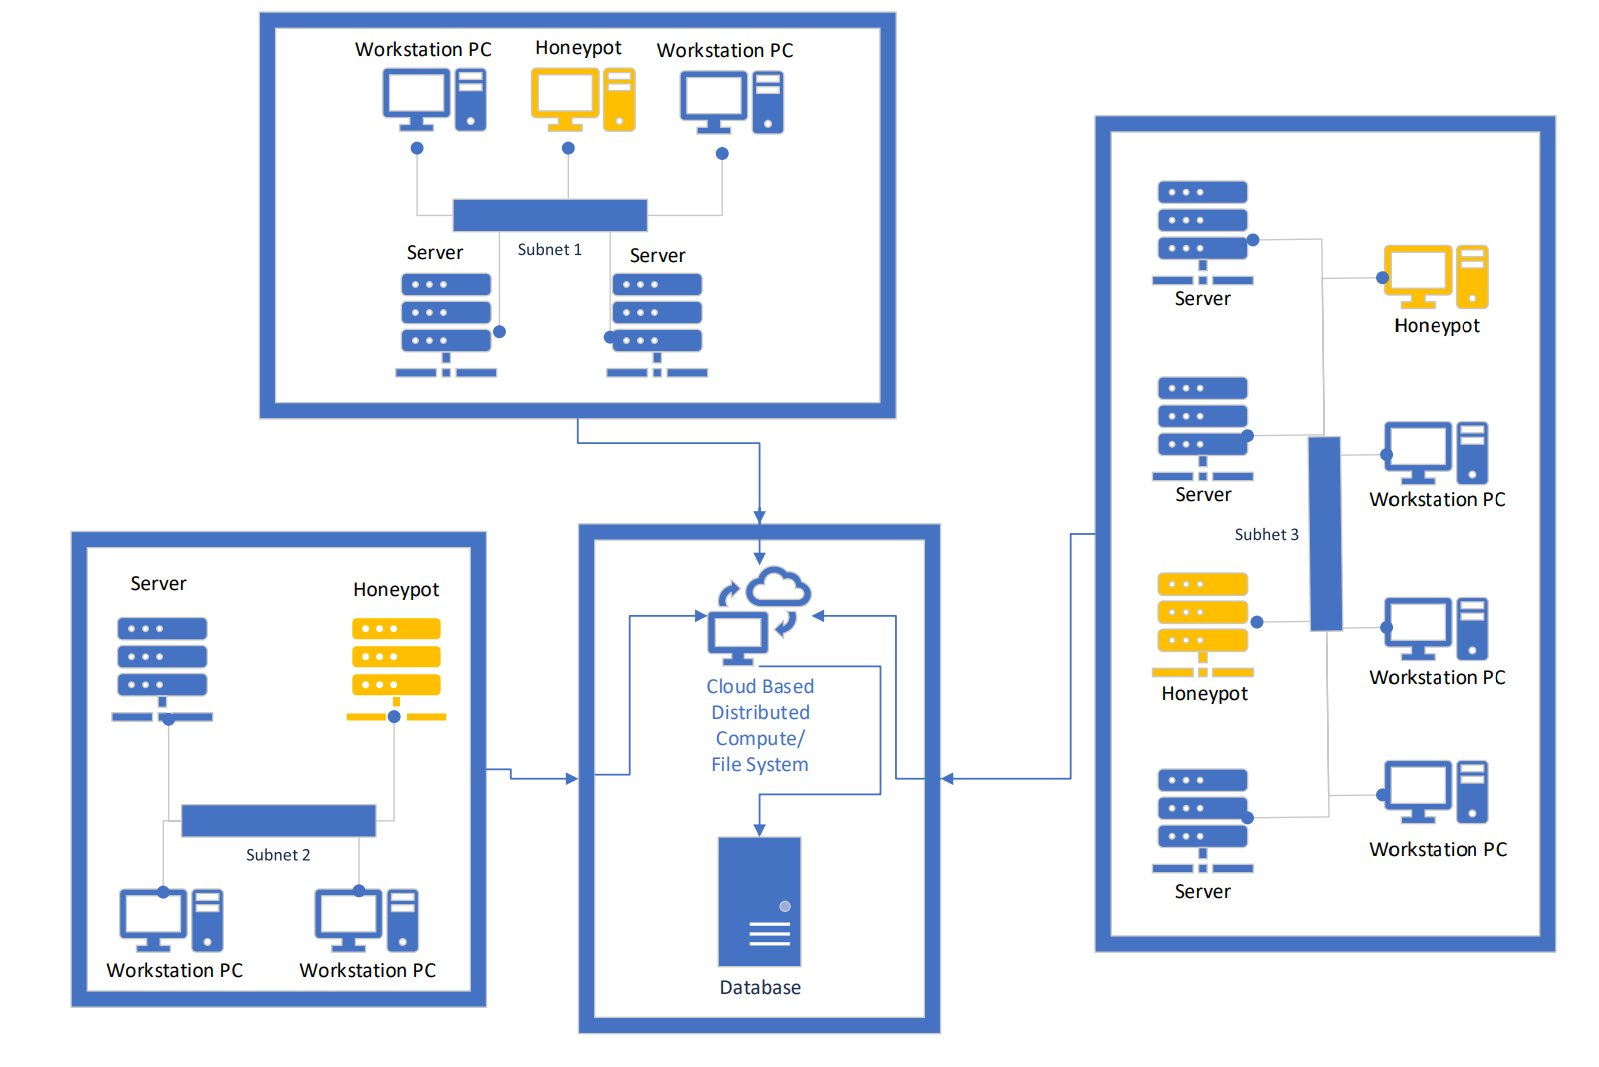

# Results (continued)

The diagram lays out how an enterprise network might look where they have 3 physical networks that may be composed of backend server machines for various applications, along with end user workstation machines. The IDS system would be composed of Honeypot devices and network monitoring applications that may be installed on the Honeypot machines, any computer running on the network, or on the network appliances like routers and access points themselves. The Honeypots are designed to look like valuable servers or workstations on the network with dummy data, but in reality, they are monitoring devices that are simply there to help with detection of intruders on the network. For our sample dataset we used honeypot and Snort data, the honeypot data was gathered using the Amun and Glastopf tools which are both low interaction honeypots that listen on different ports and record connections (Sconzo and Dehart 2014). Finding good openly available network monitoring data was a challenge but the above referenced dataset and accompanying Jupyter notebook offered both honeypot data and IDS data from Snort which is one of the most popular packet-sniffing network monitoring tools available in the open-source community. The other source of data used in this project was generated using the CICFlowMeter tool which is a packet sniffing tool like Snort that can gather more than 80 statistical network traffic features and was generated by researchers at The University of New Brunswick (UNB) (Sharafaldin et al, 2018). This dataset was also a good choice since it accompanied a research paper discussing the collection of the data and analyzing previously available open network dataset and their shortcomings. This dataset was designed to work well in machine learning applications as training data.

When it came to the process of importing the data, the UNB dataset was easily imported in both MongDB and PySpark. In Mongo there was an artifact where some of the keys had been given an extra space in front of the name, in the example cells above ‘ Label’ was required to query the database for the number of documents with the benign label. In a production environment we will need to pay close attention to how the data is exported from the IDS tool and imported into the database to ensure that issues such as this do not arise. An advantage of MongoDB is not needing to worry about a schema, while PySpark does require a schema, by default when importing data it will infer a schema if one is not provided. In the case of the UNB dataset, the inferring of schema worked well, shown in the first cell above we see the schema is mostly integers or doubles which means we have some fields with whole numbers only and some with decimals and it seems to capture that and translate it into the schema.

It also detects the Label field as string type which is correct. When we move on to importing the Sconzo and Dehart dataset, we have a different set of challenges. Firstly, we have a nested JSON file here, which would likely import easily into MongoDB but with PySpark we need to basically migrate each nested dataset into separate dataframes since we need to have continuity in terms of column names within each dataframe. So, the procedure shown above involved breaking the JSON file down based on which tool it came from and then creating three separate dataframes, one for each tool. In our production system if we use PySpark we will need to work with one dataframe for each tool we implement in the network. Also, while inferring a schema did work successfully with the UNB dataset, it did not work properly with the Sconzo and Dehart data, so it was necessary above to manually create a schema which determined the datatype for each column. This was also challenging due to the type of data, if the system was not able to convert a column to the designated datatype then the import would fail. In the production system much attention will need to be paid to designating the proper datatype for the end applications we want to use with the data.

In comparing this dataset to the dataset depicted in the “Data Modeling by Example” video, there is one major difference in how we would model the data using MongoDB or using PySpark as illustrated below: 

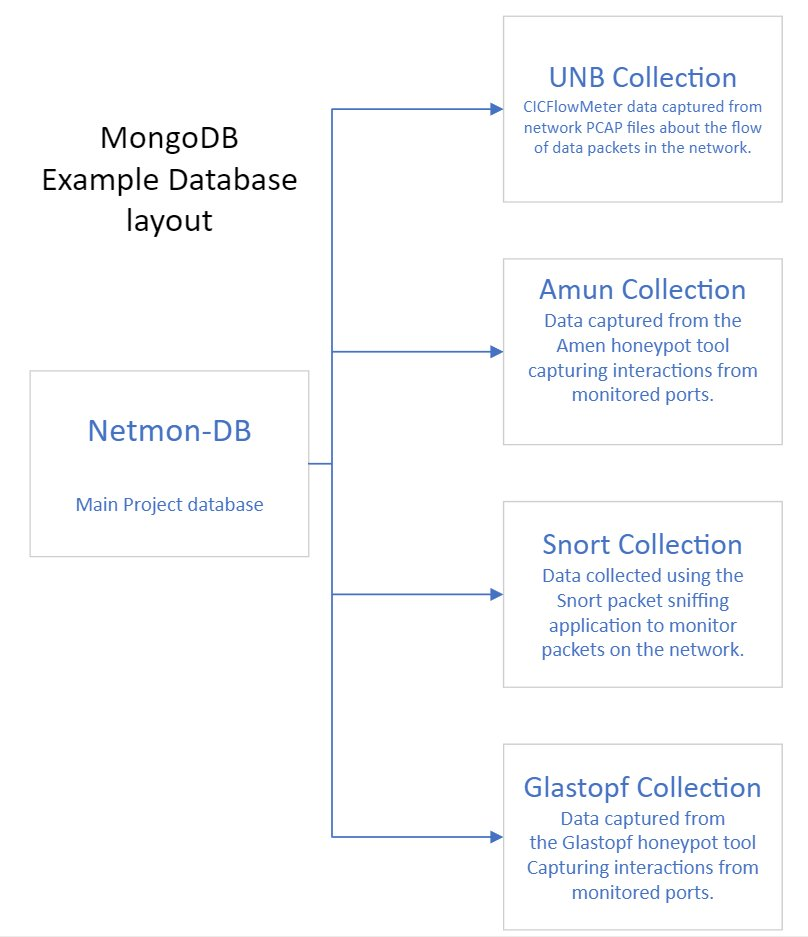

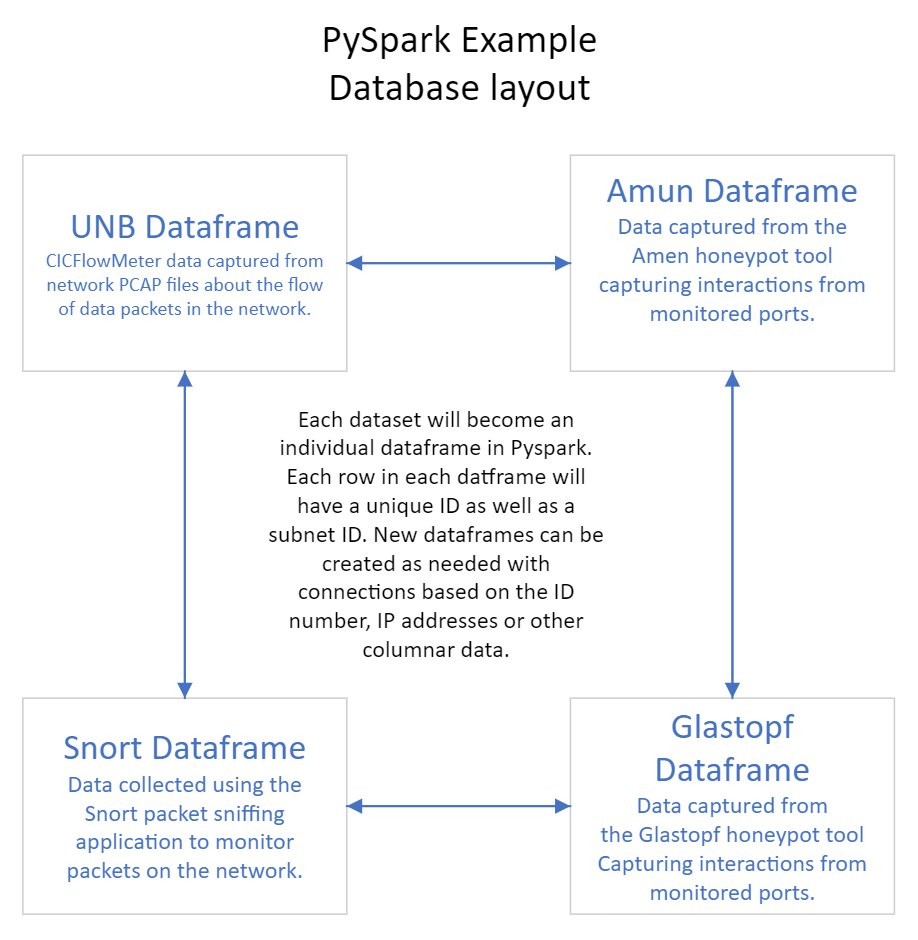

# Results (continued)

From the layout we see that the major difference between the two database options is that MongoDB will add each dataset as a collection within the same database, where in PySpark we will need to create a unique dataframe for each IDS tool type since each will have different columns. We also will need to ensure that each row within each dataframe has a unique identifier, which is done be default with most tools but may not happen with all tools. It also would be beneficial to add an ID for each subnet in the enterprise so that we can ensure that we are tracking the network locations. It will also make sense to define a schema with PySpark to ensure that we know exactly what datatypes are being assigned to each column. Mostly the columns will be either integer or double in PySpark. Exceptions include labels and IP addresses which are strings, timestamps which will need to be designated as ‘TimestampType’ and True or False data which is ‘BooleanType’.

# Discussion

The focus of this section will be discussing the end goal of the project in terms of how the IDS tools data in our distributed data store can then be used to improve security within an enterprise information system. To ensure that our data model will work in practice, some attention needs to be paid to the applications on the back end and how we will ultimately use the data to achieve business objectives. One way to relate this project back to the modelling module in the course is to look at Stonebreaker’s 10 rules and check our system to see how this plan measures up. The final discussion point will be a look at what was learned in the course and how that shaped this project overall.

To summarize the data flow within the project, here is a diagram of the way data will move within the system:


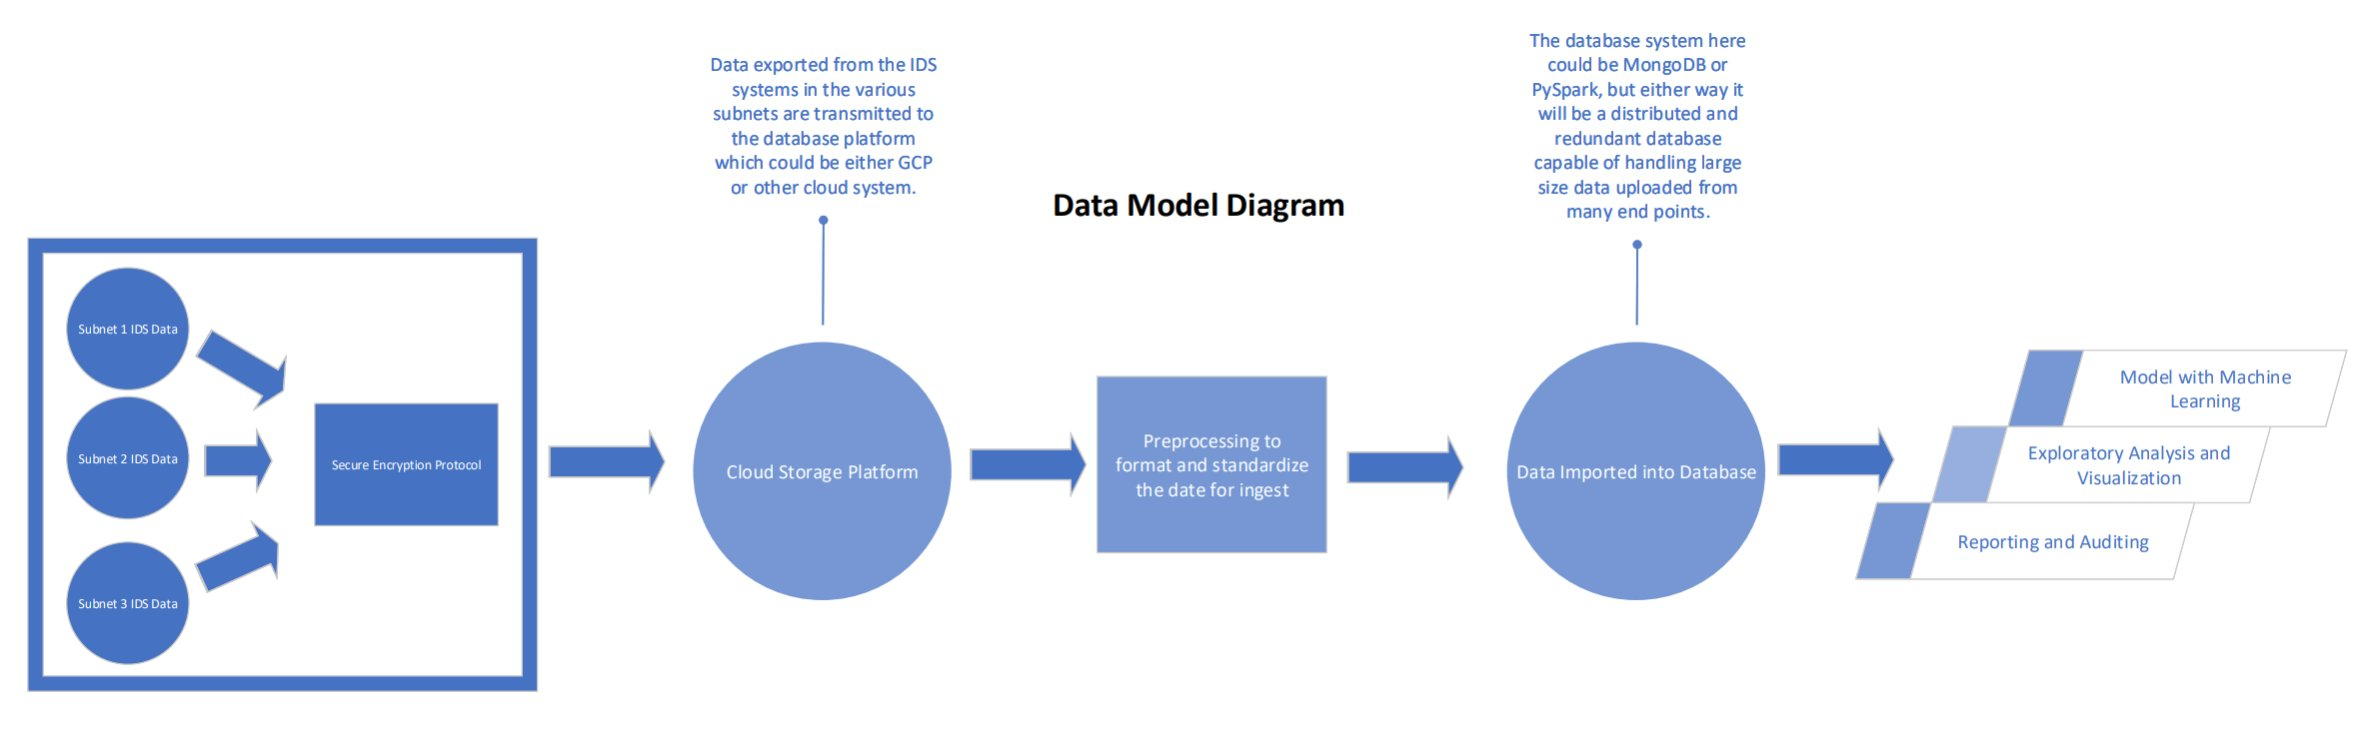

# Discussion (continued)

Of course, as this diagram shows, the key point in the diagram is the final one, where the data can be leveraged to accomplish important business goals. As discussed in the Sharafaldin paper, different features of the data will have different predictive values for different types of attack. This indicates the importance of gathering as much data at the front end as possible since the attach vectors will evolve over time, and we want to ensure that we are checking the effectiveness against these varying attacks. One approach to integrating machine learning in this data model is to connect using python and utilize libraries like SciKit-Learn and PyTorch to model the data. Python offers many ways to integrate machine learning so there’s no shortage of options but it’s important to keep in mind that moving the data into python for this modeling will give up the distributed computing benefits of the data store. One advantage of PySpark is that it has integrated machine learning that can be applied to the distributed dataframes directly, performing most of the basic machine learning functions of other libraries but leveraging the distributed computing platform (Cretan, 2022). This is one advantage of PySpark over MongoDB, enabling an automated data flow that can output relevant data for alerting and visualization after ML modeling within the distributed architecture. Another area where this system will be useful is in the field of Cybersecurity auditing which has become common practice and sometimes a legal requirement in enterprise IT. When conducting a cybersecurity audit the first step is establishing the objective of the audit (Cooke, 2019) and following the data model in the Sharafaldin article where we train our ML model on the types of attack, this will aid in the process of filtering through the large amount of data being collected to draw the data needed for our chosen audit objective.

Shifting the focus back to the course materials, let’s look at this project and see how it measures up to Stonebreaker’s 10 Rules for Scalable Performance. Below will be a brief list of each rule and how our project stacks up:

1.	Look for shared-nothing scalability: PySpark will connect to any Spark instance so it’s simple to set up a fully distributed cluster with Spark and then just point our python environment and interact with PySpark.
2.	High-level languages are good and need not hurt performance: With the combination of Spark and Python we are able to use our high-level Python code to accomplish our goals and leverage the distributed Spark system.
3.	Leverage main memory databases: This behavior is defined under pyspark.StorageLevel and can be defined in different ways but the default behavior is main memory only.
4.	High availability and automatic recovery: Again, with our Spark distributed system we will achieve this and can scale up or down our overall cluster based on our needs.
5.	Online everything: With Spark running on a cloud cluster, we should have no problem keeping availability high and making changes as needed without the need to loose connectivity.
6.	Avoid multi-node operations: This rule is about the need to ensure that a DB can scale up without having to share the data across multiple systems, here we should have no issues but we will need to decide how much data to keep in our active dataframe, with large amounts of data coming in and most of the applications being concerned with current or very recent data, the application will need to off-load older data to an archive to ensure that each node has enough memory to hold the entire dataframe.
7.	Don’t try to build ACID consistency yourself: Spark in itself, will not provide ACID guarantees, but many of the concerns are addressed. This application shouldn’t really require ACID and the way that Spark operates should get it close enough to keep the system working smoothly.
8.	Look for administrative simplicity: This is part of the reason for the popularity of Spark, it is built to manage the complexity of distributed data storage so that the focus can be on building the application using a high level language of choice.
9.	Pay attention to node performance: Attention will need to be paid to how the system performs but changes to the way Spark uses resources or to the architecture chosen at the cloud provider should allow us to maintain good node performance.
10.	Open source gives you more control over your future: This project is a great example of how open source tools can be leveraged. In theory, every component here will be open source, the IDS tools, Spark, and Python. It may be necessary or preferable to utilize closed-source tools for IDS data collection but with as many open source tools as there are available it seems unlikely.

Overall, the concepts we’ve covered in the course have been key in having the ability to conceptualize a project like this. In the module covering data types we discussed the implications of how data is organized and conceptualized, and this was important it modeling the IDS data coming into the data store for this application. The cloud computing module was helpful in understanding the idea of Platforms as a Service and that concept is key here where we can utilize either GCP or AWS or a similar platform and build our software system on top of any of these platforms. This will enable cost scalability where an organization can pay only for the amount of resource used for this type of project. Probably the most significant module for informing this project was the distributed computing and filesystems module which was key to understanding how resources can be distributed and to recognize the complexity of this type of system. While the availability of tools like Spark clearly lower the barrier to entry of distributed computing and allow an organization to focus on their specific application over the complexities of distributed resources, it’s still important to have a basic understanding of what is happening on a resource level to ensure that a system like this works well in practice.


# Conclusion

This project has helped in bringing together an important business application with the skills imparted within the course for understanding how to take a basic data concept and translate that concept to a system capable of handling modern big data requirements. The project started from a desire to find ways to further study cybersecurity concepts while focusing on the course materials and connecting the many big data management concepts we’ve learned this semester. In progressing through some significant challenges, the project ultimately put together a cohesive and actionable plan for a valuable data science and cybersecurity application. While both the database systems explored in this project were highly regarded and could work well, the challenges faced helped to point the direction toward a system that ultimately seems to be the better choice in PySpark. At the completion of this project, a foundation is laid for building a complete network monitoring application, ensuring that the tools can be used at scale to improve visibility and security for large enterprise networks.


# Resources

References
1.	IBM. “Cost of a Data Breach Report 2022”, July 2022, ibm.com/reports/data-breach
2.	Cisomag. “Importance of Intrusion Detection System in Cybersecurity.” CISO MAG | Cyber Security Magazine, 2 Dec. 2021, cisomag.com/importance-of-intrusion-detection-system-in-cybersecurity.
3.	Stonebraker, Michael, and Rick Cattell. “10 Rules for Scalable Performance in ‘simple Operation’ Datastores.” Communications of the ACM, vol. 54, no. 6, Association for Computing Machinery, June 2011, pp. 72–80.
4.	February 01, 2023 “Tutorial: Work With PySpark DataFrames on Databricks.” Databricks on AWS, docs.databricks.com/getting-started/dataframes-python.html.
5.	Sconzo, Mike and Roxy Dehart, “BSidesDFW 2014 - Honeypot How to.” 2014, nbviewer.org/url/secrepo.com/honeypot/BSidesDFW%20-%202014.ipynb
6.	Iman Sharafaldin, Arash Habibi Lashkari and Ali A. Ghorbani. Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization ICISSP 2018 - 4th International Conference on Information Systems Security and Privacy.
7.	Cretan, Pan. “Machine Learning With PySpark | Towards Data Science.” Medium, 29 Aug. 2022, towardsdatascience.com/machine-learning-on-a-large-scale-2eef3bb749ee.
8.	Cooke, Ian. “IS Audit Basics: Auditing Cybersecurity.” March 1, 2019. ISACA, www.isaca.org/resources/isaca-journal/issues/2019/volume-2/is-audit-basics-auditing-cybersecurity.

Data Sources:
1.	Honeypot data- https://www.secrepo.com/honeypot/honeypot.json.zip
2.	University of New Brunswick dataset- http://205.174.165.80/CICDataset/CIC-IDS-2017/
